<a href="https://colab.research.google.com/github/Chacon-Miguel/TESS-ZTF-Light-Curve-Classifier/blob/main/functional_vae_sim_data_80_by_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
import requests
import pandas as pd
import keras
import pickle
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random
import keras.backend as K
import tensorflow as tf
from typing import Callable
from sys import path
from google.colab import drive, files
from collections import Counter
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras import layers, Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import (GRU, Dense, Lambda, Masking, TimeDistributed, concatenate)
from keras.optimizers import Adam
from sklearn.manifold import TSNE


# Constants

In [2]:
PATH_TO_MODULE = '/content/drive/MyDrive/TESS-ZTF-Transient-Classification/'
filterwarnings("ignore")
path.append(PATH_TO_MODULE)
drive.mount('/content/drive/')

img_size = 28
num_channels = 1
num_features = 4
latent_space_dim = 2


num_timesteps = 80
latent_dimension = 10
batch_size = 64
encoder_dimensions = {
    "gru1": 175,
    "gru2": 150,
    "encoded_dimension": latent_dimension,
}
decoder_dimensions = {
    "gru5": 150,
    "gru6": 175,
    "decoder_output": (None, latent_dimension),
    "final_dimension": 80,
}

processed_data_path = PATH_TO_MODULE + 'datasets/simulated_data/processed_data/'
dataset_8_classes_path  = processed_data_path + 'dataset_8_classes.pickle'
dataset_4_classes_path  = processed_data_path + 'dataset_4_classes.pickle'
dataset_4_8K_path       = processed_data_path + 'dataset_4_8K_classes.pickle'
dataset_filepath = processed_data_path + 'dataset_8_classes.pickle'

Mounted at /content/drive/


In [3]:
# Encoder
encoder_input = Input(shape=(num_timesteps, num_features), name="encoder_input")

encoder_gru_layer1 = GRU(
    encoder_dimensions["gru1"],
    activation="tanh",
    recurrent_activation="hard_sigmoid",
    return_sequences=True,
    name="gru1",
)(encoder_input)

encoder_gru_layer2 = GRU(
    encoder_dimensions["gru2"],
    activation="tanh",
    recurrent_activation="hard_sigmoid",
    return_sequences=True,
    name="gru2",
)(encoder_gru_layer1)

encoder_mean = GRU(
    encoder_dimensions["encoded_dimension"],
    return_sequences=True,
    activation="linear",
    name="gru3",
)(encoder_gru_layer2)

# z variance output
encoder_log_variance = GRU(
    encoder_dimensions["encoded_dimension"],
    return_sequences=True,
    activation="linear",
    name="gru4",
)(encoder_gru_layer2)

def sampling(mean_log_variance):
    mean, log_variance = mean_log_variance

    tensor_shape = K.shape(mean)
    batch = tensor_shape[0]
    timesteps = tensor_shape[1]
    dimensions = tensor_shape[2]

    epsilon = K.random_normal(shape=(batch, timesteps, dimensions))
    random_sample = mean + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tf.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mean, encoder_log_variance])

encoder = tf.keras.models.Model(encoder_input, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 80, 4)]      0           []                               
                                                                                                  
 gru1 (GRU)                     (None, 80, 175)      95025       ['encoder_input[0][0]']          
                                                                                                  
 gru2 (GRU)                     (None, 80, 150)      147150      ['gru1[0][0]']                   
                                                                                                  
 gru3 (GRU)                     (None, 80, 10)       4860        ['gru2[0][0]']                   
                                                                                      

In [4]:
encoded_input = Input(shape=(num_timesteps, latent_dimension), name="encoder output")
time_and_band_input = Input(shape=(num_timesteps, 2), name='time and band input')
concatenate_mask_input = Input(shape=(num_timesteps, latent_dimension + 2), name = 'concatenate_mask')
decoder_output_mask_input = Input(shape=(num_timesteps, decoder_dimensions['final_dimension']), name='decoder_output_mask')

concatenated_tensor_without_masking = concatenate((encoder_output, time_and_band_input), axis=-1)
concatenated = tf.math.multiply(concatenated_tensor_without_masking, concatenate_mask_input)

# first recurrent layer
decoder_gru_layer1 = GRU(
    decoder_dimensions["gru5"],
    activation="tanh",
    recurrent_activation="hard_sigmoid",
    return_sequences=True,
    name="gru5",
)(concatenated)

# second recurrent layer
decoder_gru_layer2 = GRU(
    decoder_dimensions["gru6"],
    activation="tanh",
    recurrent_activation="hard_sigmoid",
    return_sequences=True,
    name="gru6",
)(decoder_gru_layer1)

# decoder output
decoder_output_without_masking = TimeDistributed(
    Dense(
        decoder_dimensions["final_dimension"],
        activation="tanh",
        input_shape=decoder_dimensions["decoder_output"],
    ),
    name="td",
)(decoder_gru_layer2)

decoder_output = tf.math.multiply(decoder_output_without_masking, decoder_output_mask_input)

decoder = tf.keras.models.Model([encoder_output, time_and_band_input, concatenate_mask_input, decoder_output_mask_input], decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 10)]     0           []                               
                                                                                                  
 time and band input (InputLaye  [(None, 80, 2)]     0           []                               
 r)                                                                                               
                                                                                                  
 concatenate (Concatenate)      (None, 80, 12)       0           ['input_1[0][0]',                
                                                                  'time and band input[0][0]']    
                                                                                      

In [ ]:
tf.keras.utils.plot_model(encoder, show_shapes=True, show_dtype=True)

In [ ]:
tf.keras.utils.plot_model(decoder, show_shapes=True, show_dtype=True)

In [5]:
vae_input = Input(shape=(num_timesteps, num_features), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_time_and_band_input = Input(shape=(num_timesteps, 2), name='VAE_time_and_band_input')
vae_concatenate_mask_input = Input(shape=(num_timesteps, latent_dimension + 2), name = 'VAE_concatenate_mask')
vae_decoder_output_mask_input = Input(shape=(num_timesteps, decoder_dimensions['final_dimension']), name='VAE_decoder_output_mask')
vae_decoder_output = decoder([vae_encoder_output, vae_time_and_band_input, vae_concatenate_mask_input, vae_decoder_output_mask_input])

vae = Model([vae_input, vae_time_and_band_input, vae_concatenate_mask_input, vae_decoder_output_mask_input], vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 VAE_input (InputLayer)         [(None, 80, 4)]      0           []                               
                                                                                                  
 encoder_model (Functional)     (None, 80, 10)       251895      ['VAE_input[0][0]']              
                                                                                                  
 VAE_time_and_band_input (Input  [(None, 80, 2)]     0           []                               
 Layer)                                                                                           
                                                                                                  
 VAE_concatenate_mask (InputLay  [(None, 80, 12)]    0           []                             

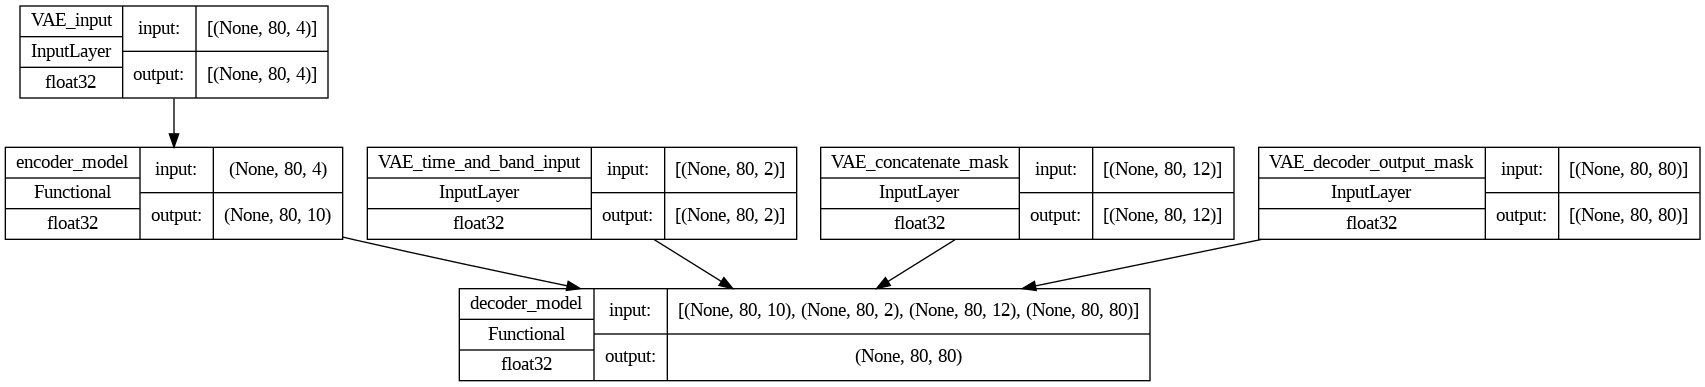

In [15]:
tf.keras.utils.plot_model(vae, show_shapes=True, show_dtype=True)

In [6]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        # reconstruction_loss_factor = 1
        # reconstruction_loss = tf.keras.backend.log(tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3]))
        # return reconstruction_loss_factor * reconstruction_loss
        return K.log(K.mean(K.square(y_true - y_predict)))

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        # kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        kl_loss = -0.5 * tf.reduce_mean(encoder_log_variance - tf.square(encoder_mu) - tf.exp(encoder_log_variance) + 1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mean, encoder_log_variance))

## Loading the Data and Training the Model

In [7]:
def compute_concatenate_masks(x_train, size):
    masks = []
    for light_curve in x_train:
        mask = []
        for time, band, flux, error in light_curve:
            if band == 0:
                mask.append([0.0] * (size))
            else:
                mask.append([1.0] * (size))
        masks.append(mask)

    return np.array(masks)

def compute_decoder_output_masks(num_light_curves):
    light_curve_mask_array = [
        [1] * numb + [0] * (80 - numb) for numb in range(1, 81)
    ]
    light_curve_mask = np.array(light_curve_mask_array).T
    light_curve_masks = np.repeat(
        np.array([light_curve_mask]), num_light_curves, axis=0
    ).astype(np.float32)
    return light_curve_masks

def normalize_dataset(dataset):
    # normalize data using min-max range
    for i, xarr in enumerate(dataset):
        mask = np.where(xarr[:, 2:3] != 0)[0]
        maxval = xarr[:, 2:3][mask].max()
        minval = xarr[:, 2:3][mask].min()
        dataset[i, :, 2:3][mask] = dataset[i, :, 2:3][mask] / (maxval - minval)
        dataset[i, :, 3:4][mask] = dataset[i, :, 3:4][mask] / (maxval - minval)
    return dataset
"""
Each path leads to pickle file that holds a dictionary that looks like this:
  dataset = {
    'names':    numpy array of size (n_objects)
    'labels':   numpy array of size (n_objects)
    'lc':       numpy array of size (n_objects, n_timesteps, 4)
    'r-shifts': numpy array of size (n_objects)
  }
"""
with open(dataset_filepath, "rb") as file:
    data = pickle.load(file)

names, labels, dataset, redshifts = data.values()

dataset = normalize_dataset(dataset)
num_light_curves = dataset.shape[0]

Split Training Data

In [8]:
test_size = 0.25
# def split_training_data(, test_size: float = 0.25):
"""
Splits data into 3/4 training, 1/4 testing
"""
# assert self.dataset != None
y = dataset[:, :, 2].reshape(num_light_curves, num_timesteps, 1)

x = dataset
(x_train, x_test,
  y_train, y_test,
  names_train, names_test,
  labels_train, labels_test,
  redshifts_train, redshifts_test) = train_test_split(
    x, y, names, labels, redshifts, test_size=test_size
)

# make y_train and y_test into 80 by 80 sets that are also masked
y_train_mask = compute_decoder_output_masks(y_train.shape[0])
y_test_mask = compute_decoder_output_masks(y_test.shape[0])

y_train = np.repeat(y_train, num_timesteps, axis=2)# * y_train_mask
y_test = np.repeat(y_test, num_timesteps, axis=2)# * y_test_mask

y_train = y_train * y_train_mask
y_test = y_test * y_test_mask

In [13]:
def get_outputs_for_light_curve(x_train, index=None):
    if not index:
      index = 0
    num_timesteps, num_features = x_train[index].shape
    light_curve = x_train[index].reshape(1, num_timesteps, num_features)
    time_and_band = light_curve[:, :, :2]
    # elif light_curve.all() != None:
    #     num_timesteps, num_features = self.x_train[0].shape
    #     light_curve = self.x_train[index].reshape(1, num_timesteps, num_features)
    #     time_and_band = light_curve[:, :, :2]

    # masks for concatenate layer: add 2 for time and band columns
    concatenate_mask = compute_concatenate_masks(
        light_curve, latent_dimension + 2
    )

    # now make y_train and y_test 80 by 80 to match the output of the decoder
    dec_output_mask = compute_decoder_output_masks(1)

    # z_mean, z_log_var, z = vae.encoder.predict(light_curve)

    inputs = [light_curve, time_and_band, concatenate_mask, dec_output_mask]

    # reconstructed = vae.decoder.predict(decoder_input)
    reconstructed = vae.predict(inputs)
    return reconstructed

In [11]:
# should be (1, timesteps, timesteps)
def plot_true_and_predicted_light_curve(vae, training_set, names, labels, index = 0):
  # USING TRAINING SET CURRENTLY
  # training_set = vae.x_train
  # names = vae.names_train
  # labels = vae.labels_train

  f, ax = plt.subplots(1)
  time_idx, band_idx, flux_idx, error_idx = list(range(4))
  light_curve = training_set[index]
  time_values = light_curve[:, time_idx]
  true_flux_values = light_curve[:, flux_idx]
  model_output = get_outputs_for_light_curve(training_set, index)
  # (80, 80)
  predicted_light_curves = model_output[0]

  # uncomment this to plot only the fully predicted light curve at timestep 80
  predicted_light_curve = predicted_light_curves[:, num_timesteps-1][:num_timesteps]
  print(predicted_light_curve)

  red_flux_values = predicted_light_curve[light_curve[:, band_idx] == 6.2]
  # red_flux_values = red_values[:, flux_idx]
  red_values = light_curve[light_curve[:, band_idx] == 6.2]
  red_time_values = red_values[:, time_idx]

  green_flux_values = predicted_light_curve[light_curve[:, band_idx] == 4.8]
  green_values = light_curve[light_curve[:, band_idx] == 4.8]
  green_time_values = green_values[:, time_idx]

  ax.scatter(red_time_values, red_flux_values, marker='x', color='deeppink')
  ax.scatter(green_time_values, green_flux_values, marker='x', color='aquamarine')

  # ax.scatter(time_values[:vae.num_timesteps+1], predicted_light_curve, marker='.', alpha=0.5)
  # print(predicted_light_curves[:, time_idx:band_idx])

  # plot every predicted light curve
  for timestep in range(num_timesteps):
    predicted_light_curve = predicted_light_curves[:, timestep][:timestep+1]
    # ax.scatter(time_values[:timestep+1], predicted_light_curve, marker='.', alpha=0.5)  # label = f'{timestep}')
  # ax.scatter(time_values, true_flux_values, marker='.')

  # plot actual light curve

  red_values = light_curve[light_curve[:, band_idx] == 6.2]
  red_flux_values = red_values[:, flux_idx]
  red_time_values = red_values[:, time_idx]

  green_values = light_curve[light_curve[:, band_idx] == 4.8]
  green_flux_values = green_values[:, flux_idx]
  green_time_values = green_values[:, time_idx]

  ax.scatter(red_time_values, red_flux_values, marker='.', color='red')
  ax.scatter(green_time_values, green_flux_values, marker='.', color='green')

  f.suptitle(f'light curve {names[index]} of class {labels[index]}')
  # ax.legend(loc='best')
  f.show()


# index = 0
# # print(vae.x_test[index])
# for i in range(5):
#   plot_true_and_predicted_light_curve(i)
# plot_true_and_predicted_light_curve(1000)
# plot_true_and_predicted_light_curve(2000)
# plot_true_and_predicted_light_curve(3000)

In [21]:
def get_dataset(dataset_filepath):
  with open(dataset_filepath, "rb") as file:
      data = pickle.load(file)

  names, labels, dataset, redshifts = data.values()

  dataset = normalize_dataset(dataset)
  num_light_curves = dataset.shape[0]
  return names, labels, dataset, redshifts

In [17]:
def split_training_data(dataset, test_size: float = 0.25):
    """
    Splits data into 3/4 training, 1/4 testing
    """
    # assert self.dataset != None
    y = dataset[:, :, 2].reshape(num_light_curves, num_timesteps, 1)

    x = dataset
    (x_train, x_test,
      y_train, y_test,
      names_train, names_test,
      labels_train, labels_test,
      redshifts_train, redshifts_test) = train_test_split(
        x, y, names, labels, redshifts, test_size=test_size
    )

    # make y_train and y_test into 80 by 80 sets that are also masked
    y_train_mask = compute_decoder_output_masks(y_train.shape[0])
    y_test_mask = compute_decoder_output_masks(y_test.shape[0])

    y_train = np.repeat(y_train, num_timesteps, axis=2)# * y_train_mask
    y_test = np.repeat(y_test, num_timesteps, axis=2)# * y_test_mask

    y_train = y_train * y_train_mask
    y_test = y_test * y_test_mask

    return (x, y, x_train, x_test, y_train, y_test, names_train, names_test, labels_train, labels_test, redshifts_train, redshifts_test)

In [45]:
# Architecture tests
# first just train with just two objects from some class
# then train with just the SNIa-x class
def architecture_test(vae, epochs, label='SNIa-x', num_objects=2):
  latent_dimension = 10
  processed_data_path = PATH_TO_MODULE + 'datasets/simulated_data/processed_data/'
  dataset_8_classes_path  = processed_data_path + 'dataset_8_classes.pickle'
  dataset_4_classes_path  = processed_data_path + 'dataset_4_classes.pickle'
  dataset_4_8K_path       = processed_data_path + 'dataset_4_8K_classes.pickle'
  dataset_filepath = processed_data_path + 'dataset_8_classes.pickle'

  # vae = VAE(latent_dimension)
  names, labels, dataset, redshifts = get_dataset(dataset_filepath)
  (x, y, x_train, x_test, y_train, y_test, names_train, names_test, labels_train, labels_test, redshifts_train, redshifts_test) = split_training_data(dataset)

  get_label = labels_train == label

  x_train = x_train[get_label]
  names_train = names_train[get_label]
  y_train = y_train[get_label]
  labels_train = labels_train[get_label]

  # fit model with just two objects
  # num_objects = 2
  x_train = x_train[:num_objects]
  x_test  = x_test[:num_objects]
  y_train = y_train[:num_objects]
  y_test  = y_test[:num_objects]

  train_time_and_band = x_train[:, :, :2]
  test_time_and_band = x_test[:, :, :2]

  # masks for concatenate layer: add 2 for time and band columns
  train_concatenate_masks = compute_concatenate_masks(
      x_train, latent_dimension + 2
  )
  test_concatenate_masks = compute_concatenate_masks(
      x_test, latent_dimension + 2
  )

  # now make y_train and y_test 80 by 80 to match the output of the decoder
  train_dec_output_masks = compute_decoder_output_masks(
      x_train.shape[0]
  )
  test_dec_output_masks = compute_decoder_output_masks(x_test.shape[0])

  print("fitting model...")
  training_data = [
      x_train,
      train_time_and_band,
      train_concatenate_masks,
      train_dec_output_masks,
  ]
  validation_data = [
      x_test,
      test_time_and_band,
      test_concatenate_masks,
      test_dec_output_masks,
  ]

  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, decay=0)
  vae.compile(optimizer=optimizer, loss=loss_func(encoder_mean, encoder_log_variance))

  print([array.shape for array in training_data])
  history = vae.fit(
      training_data,
      y_train,
      epochs=epochs,
      batch_size=64,
      validation_data=(validation_data, y_test),
      verbose=1,
      shuffle=False,
      callbacks = [tensorboard_callback]
  )

  # plot losses
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("model loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(["train", "val"], loc="upper left")
  plt.show()


  plot_true_and_predicted_light_curve(vae, x_train, names_train, labels_train, 0)
  plot_true_and_predicted_light_curve(vae, x_train, names_train, labels_train, 1)

  return vae, history


fitting model...
[(2, 80, 4), (2, 80, 2), (2, 80, 12), (2, 80, 80)]
Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: -4.1298 - val_loss: -3.3633
Epoch 2/100
1/1 [==============================] - 1s 713ms/step - loss: -3.3383 - val_loss: -3.6178
Epoch 3/100
1/1 [==============================] - 1s 655ms/step - loss: -3.8382 - val_loss: -3.5403
Epoch 4/100
1/1 [==============================] - 1s 710ms/step - loss: -4.0253 - val_loss: -3.9542
Epoch 5/100
1/1 [==============================] - 1s 702ms/step - loss: -4.5920 - val_loss: -3.9855
Epoch 6/100
1/1 [==============================] - 1s 654ms/step - loss: -4.4189 - val_loss: -3.8508
Epoch 7/100
1/1 [==============================] - 1s 665ms/step - loss: -4.4200 - val_loss: -3.7313
Epoch 8/100
1/1 [==============================] - 1s 678ms/step - loss: -4.5867 - val_loss: -3.6486
Epoch 9/100
1/1 [==============================] - 1s 698ms/step - loss: -4.6224 - val_loss: -3.7523
Epoch 10/100
1/1 [======

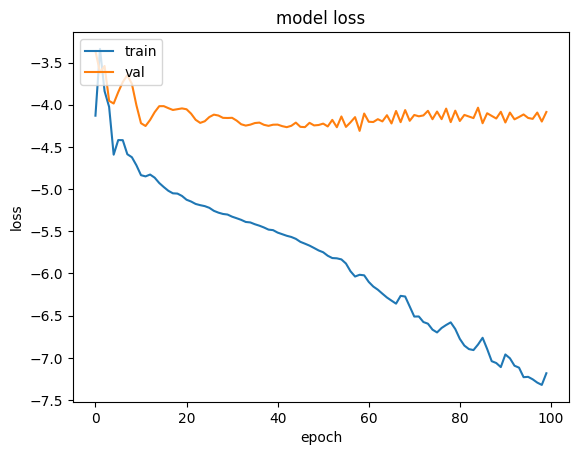

1/1 [==============================] - 2s 2s/step
[-5.96254803e-02 -1.15718178e-01  1.22998528e-01 -2.84896120e-02
  9.55233723e-03  1.59870069e-02  1.64019495e-01  4.85390335e-01
  5.31002283e-01  2.50392348e-01  6.51322484e-01  2.21951842e-01
  1.70938730e-01  1.39237821e-01  9.54371616e-02  8.74512643e-02
  4.52641509e-02  4.85454537e-02  1.01988040e-01 -3.39480266e-02
  7.05407858e-02  3.82349491e-02  6.83598453e-03 -6.16857000e-02
 -5.34416847e-02 -3.81777547e-02 -2.83147506e-02 -2.78947577e-02
 -9.04881302e-03  5.62384762e-02  1.30548060e-03 -1.32195065e-02
 -5.32953488e-03 -1.60234701e-02  6.52055219e-02  2.29958743e-01
  2.40852803e-01  2.91991055e-01  4.67298627e-01  5.52091599e-01
  8.19373846e-01  5.38732886e-01  4.07312483e-01  3.08839470e-01
  2.37887055e-01  1.80154175e-01  1.91912755e-01  2.63223559e-01
  9.59154144e-02  9.38824713e-02 -2.85366606e-02 -1.58417560e-02
 -1.70419328e-02 -1.12040471e-02 -2.62669940e-03  3.28264409e-03
  5.47357928e-03  5.24544623e-03  4.0976

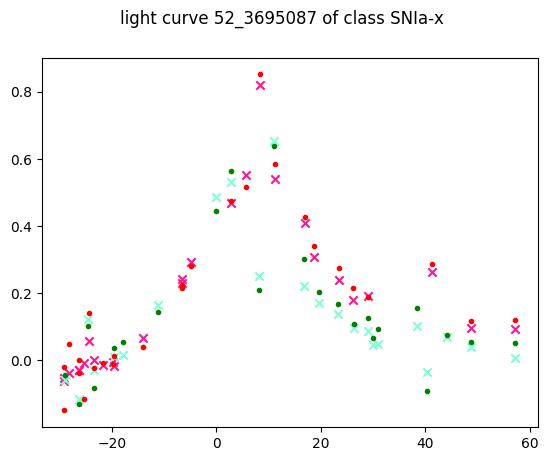

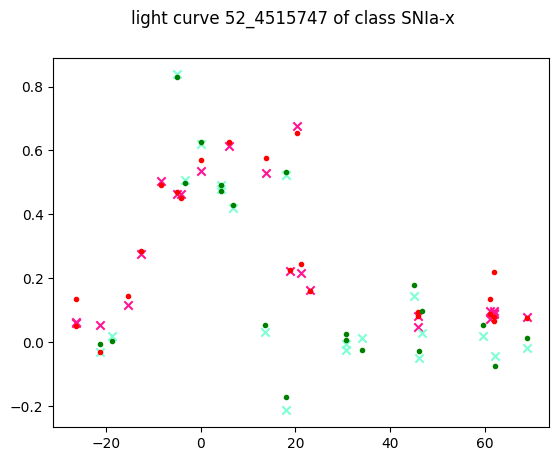

In [40]:
# with latent space of 80 by 10
epochs = 100
architecture_test(vae, epochs, num_objects=2)

fitting model...
[(1513, 80, 4), (1513, 80, 2), (1513, 80, 12), (1513, 80, 80)]
Epoch 1/100
24/24 [==============================] - 53s 2s/step - loss: -6.4101 - val_loss: -6.0910
Epoch 2/100
24/24 [==============================] - 40s 2s/step - loss: -6.7937 - val_loss: -6.7191
Epoch 3/100
24/24 [==============================] - 39s 2s/step - loss: -7.0679 - val_loss: -6.5083
Epoch 4/100
24/24 [==============================] - 39s 2s/step - loss: -7.6168 - val_loss: -7.2377
Epoch 5/100
24/24 [==============================] - 42s 2s/step - loss: -7.5119 - val_loss: -6.3855
Epoch 6/100
24/24 [==============================] - 40s 2s/step - loss: -7.4155 - val_loss: -7.2400
Epoch 7/100
24/24 [==============================] - 40s 2s/step - loss: -7.6383 - val_loss: -6.5612
Epoch 8/100
24/24 [==============================] - 36s 2s/step - loss: -7.5898 - val_loss: -6.7167
Epoch 9/100
24/24 [==============================] - 42s 2s/step - loss: -7.4087 - val_loss: -7.7486
Epoch 10/10

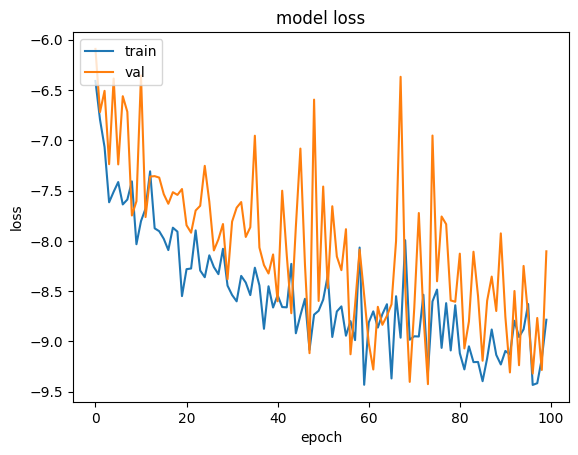

1/1 [==============================] - 2s 2s/step
[ 0.12504487  0.13298889  0.19105577  0.19558394 -0.02343344 -0.02662312
 -0.00496008  0.04460252  0.05152264 -0.03599422  0.0160404   0.05894479
 -0.01473805  0.0139941   0.03431023  0.0206822   0.0379375   0.03734203
  0.01678326  0.04925285  0.01914649  0.02666395  0.01909496 -0.07209751
  0.10855828  0.08499462  0.16717806  0.0707716   0.14679347 -0.20751327
  0.09354984  0.08807737  0.17983694  0.24134742  0.2193814   0.14909163
  0.15823834  0.14491946  0.10280318  0.11764825 -0.0723789   0.01593419
 -0.01351327  0.02264667  0.01360419  0.02011211  0.02297306 -0.00077807
  0.01339921  0.00290689  0.01529436  0.01175093  0.02626311  0.00233416
  0.00993884  0.04561315 -0.00219737  0.03057095  0.04135001  0.03330801
  0.23837997  0.19382283  0.03049618  0.7606085   0.08954446  0.40987104
  0.19851214  0.20301412  0.1821199   0.15287983  0.18618935  0.15975748
  0.23143046  0.16914213  0.21333413  0.22430754  0.18073879  0.15312558
 

TypeError: ignored

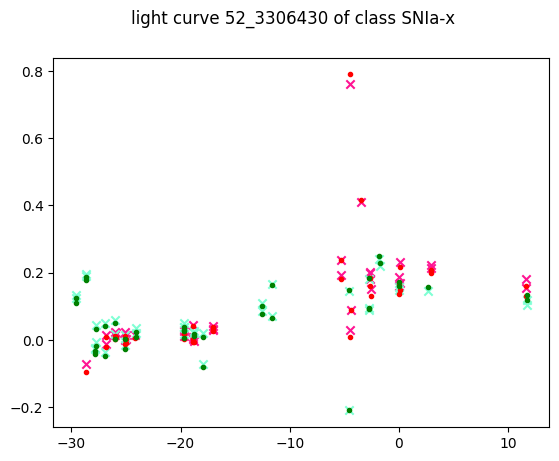

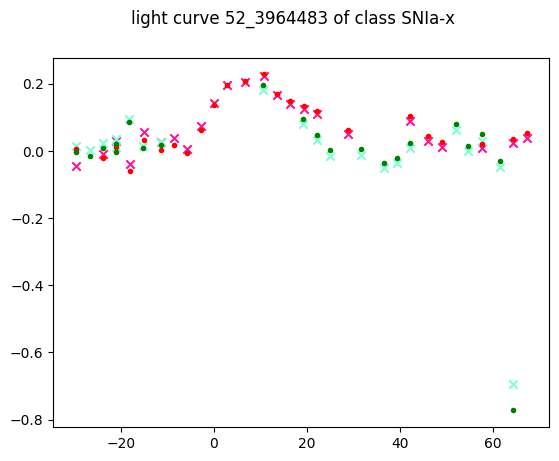

In [44]:
label='SNIa-x'
# with latent space of 80 by 10
epochs = 100
num_objects = len(x_train[labels_train == label])
vae, history = architecture_test(vae, epochs, num_objects=num_objects)

In [ ]:
label='SNIa-x'
# with latent space of 80 by 10
epochs = 10
num_objects = len(x_train[labels_train == label])
vae, history = architecture_test(vae, epochs, num_objects=num_objects)

# TRAINING NEURAL NETWORK

fitting model...
Epoch 1/5
188/188 [==============================] - 276s 1s/step - loss: -4.1906 - val_loss: -5.5906
Epoch 2/5
188/188 [==============================] - 278s 1s/step - loss: -6.3427 - val_loss: -6.4471
Epoch 3/5
188/188 [==============================] - 259s 1s/step - loss: -7.0276 - val_loss: -7.6699
Epoch 4/5
188/188 [==============================] - 257s 1s/step - loss: -7.3651 - val_loss: -7.3591
Epoch 5/5
187/188 [============================>.] - ETA: 1s - loss: -7.6619
Epoch 5: saving model to /content/drive/MyDrive/TESS-ZTF-Transient-Classification/training_ckpts/80by80_architecture/functional_vae_sim_data_80_by_80/cp-0005.ckpt


188/188 [==============================] - 278s 1s/step - loss: -7.6644 - val_loss: -7.7188


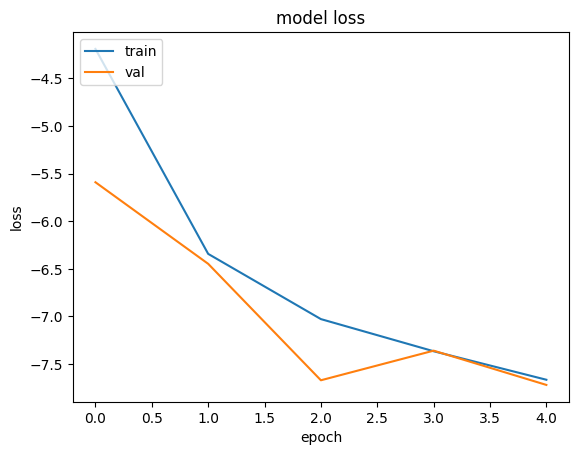

In [9]:
save_checkpoint_path = PATH_TO_MODULE + "training_ckpts/80by80_architecture/functional_vae_sim_data_80_by_80/"
epochs = 5
# optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, decay=0)
# vae.compile(optimizer=optimizer, loss=vae.reconstruction_loss)

# history = vae.train_model(save_checkpoint_path)
# with open(save_checkpoint_path + 'history_4', 'wb') as file:
  # pickle.dump(history.history, file)
"""
Trains the NN on training data

Returns the trained model.
"""
# fit model
train_time_and_band = x_train[:, :, :2]
# assert (train_inp_two.shape == (x_train[0], x_train[1], 2))

test_time_and_band = x_test[:, :, :2]
# assert (test_inp_two.shape == (x_test[0], x_test[1], 2))

# masks for concatenate layer: add 2 for time and band columns
train_concatenate_masks = compute_concatenate_masks(x_train, latent_dimension + 2)
test_concatenate_masks = compute_concatenate_masks(x_test, latent_dimension + 2)

# now make y_train and y_test 80 by 80 to match the output of the decoder
train_dec_output_masks = compute_decoder_output_masks(x_train.shape[0])
test_dec_output_masks = compute_decoder_output_masks(x_test.shape[0])

print("fitting model...")
training_data = [
    x_train,
    train_time_and_band,
    train_concatenate_masks,
    train_dec_output_masks,
]
validation_data = [
    x_test,
    test_time_and_band,
    test_concatenate_masks,
    test_dec_output_masks,
]

# Create a callback that saves the model's weights every 5 epochs
checkpoint_path = "cp-{epoch:04d}.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_checkpoint_path + checkpoint_path,
    verbose=1,
    # save_weights_only=True,
    save_freq=5 * round(y_train.shape[0] / batch_size),
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

callbacks_list = [early_stopping_callback, checkpoint_callback]

vae.save_weights(checkpoint_path.format(epoch=0))

history = vae.fit(
    training_data,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_data, y_test),
    verbose=1,
    shuffle=False,
    callbacks=callbacks_list,
)

# plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()
with open(save_checkpoint_path + 'history', 'wb') as file:
  pickle.dump(history.history, file)

1/1 [==============================] - 0s 137ms/step
[-3.80984917e-02  7.31237903e-02  4.99527976e-02  2.76258856e-01
  3.57362360e-01  4.58231807e-01  4.27368283e-01 -2.18639690e-02
  3.93276028e-02  3.72550148e-03 -5.01245260e-02  4.62965310e-01
  1.95452068e-02 -1.74700227e-02 -2.09890623e-02 -1.13348290e-01
  3.10679004e-02 -4.49485481e-02 -6.20646402e-03  2.01482236e-01
 -7.46556669e-02  3.66643332e-02  3.67919914e-02  1.61747672e-02
  7.76654184e-01  1.49562806e-01  2.07968995e-01  3.37624997e-01
  6.10555410e-01  3.05146873e-01  5.02022684e-01  4.73774582e-01
  2.13910371e-01  3.35677207e-01  3.04083914e-01  2.74374276e-01
  1.13377698e-01  1.40262619e-01  1.09712392e-01 -9.64965969e-02
 -2.08201021e-01  1.86016411e-02  5.62751628e-02  8.76325592e-02
  5.08012287e-02  3.57008278e-02  1.00077026e-01  8.42810646e-02
  1.05159013e-02  9.56087001e-03  4.65923082e-03  2.85556610e-03
  1.72951620e-03  8.95834179e-04  4.44269681e-04  3.16118822e-04
  3.67230736e-04  4.76155343e-04  5.7

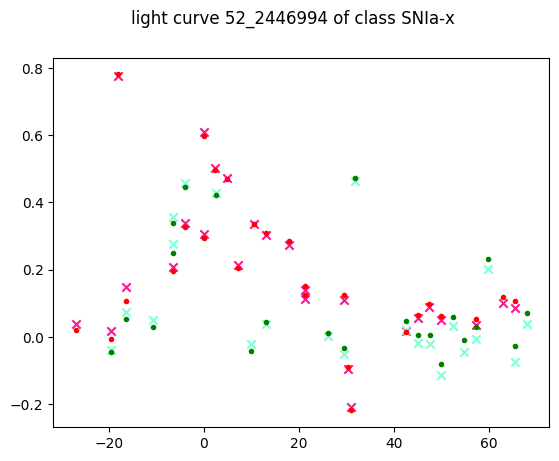

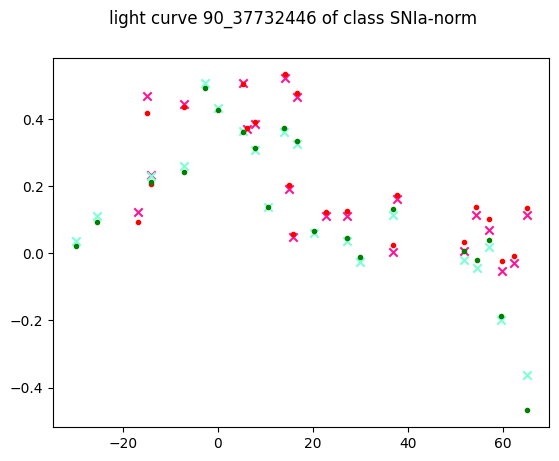

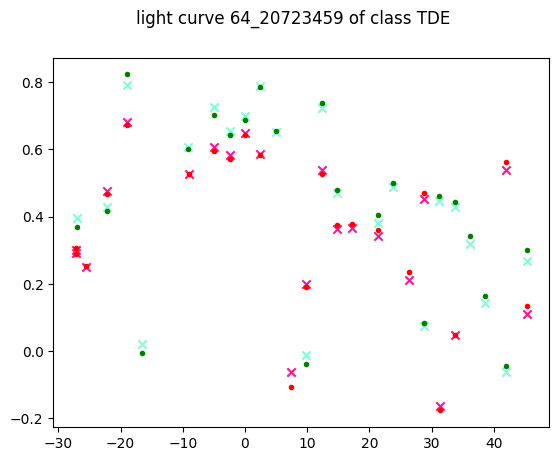

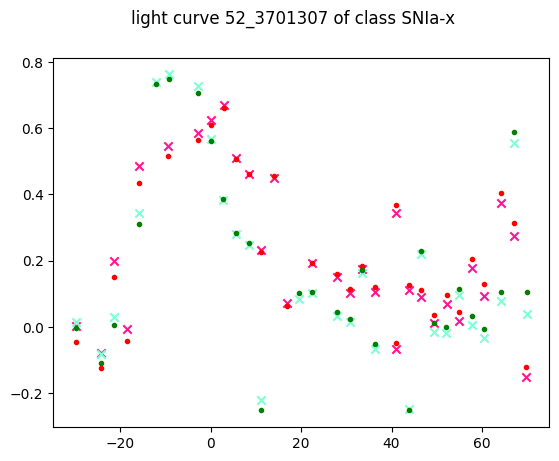

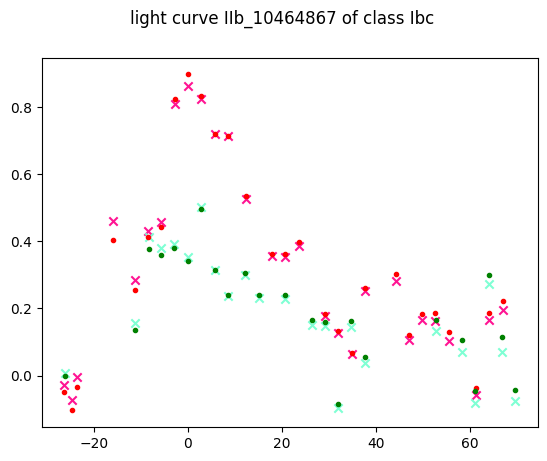

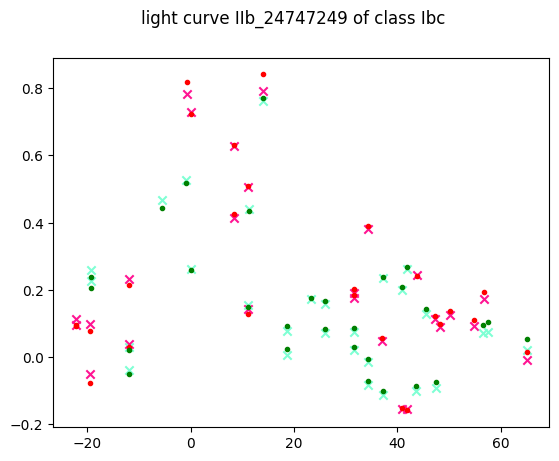

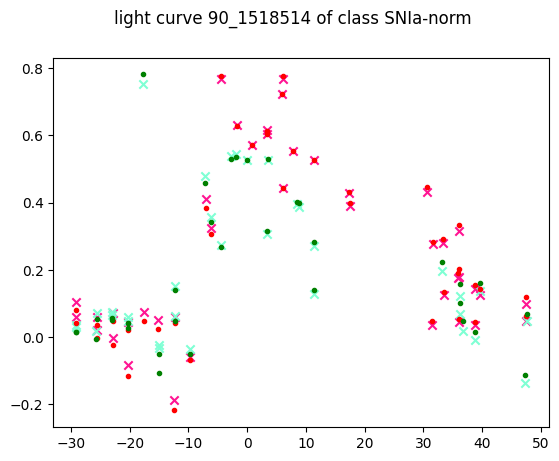

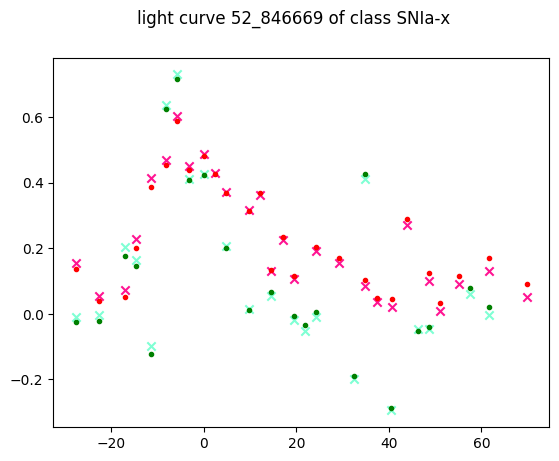

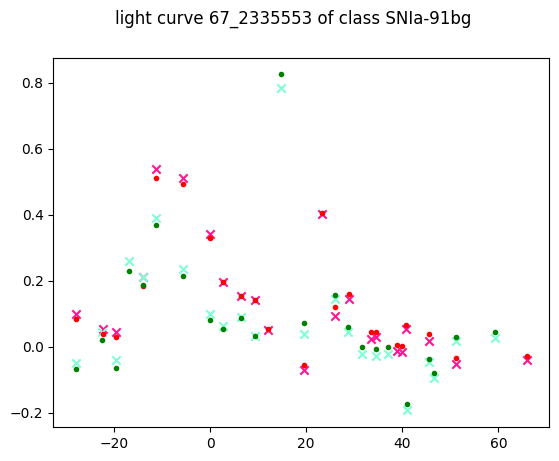

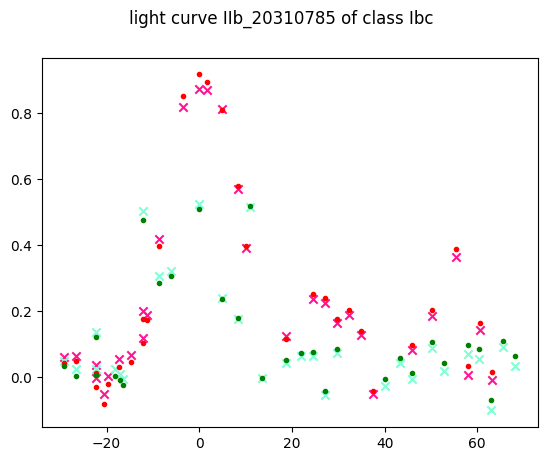

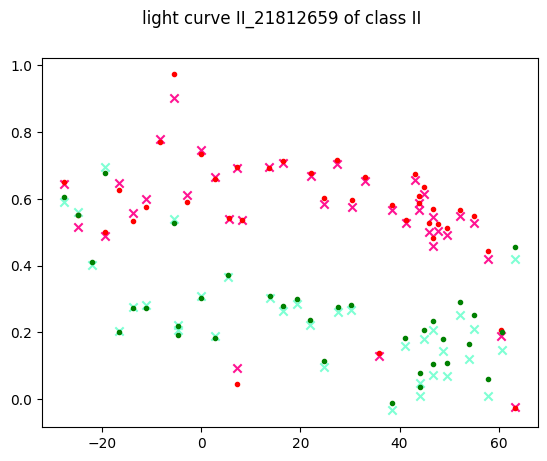

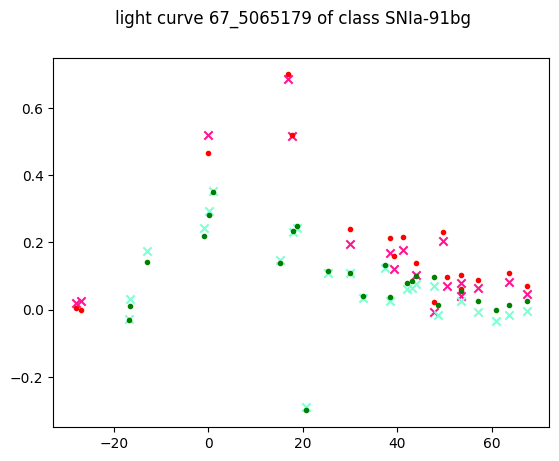

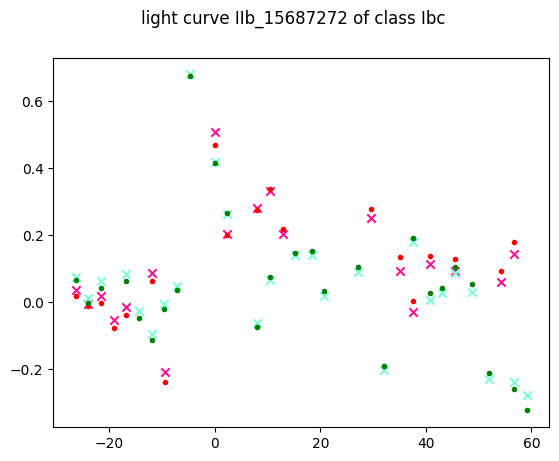

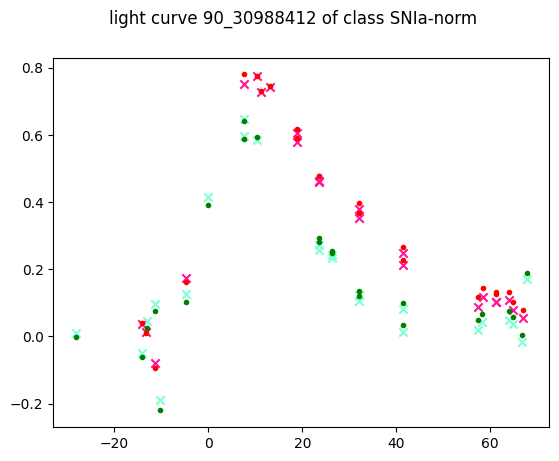

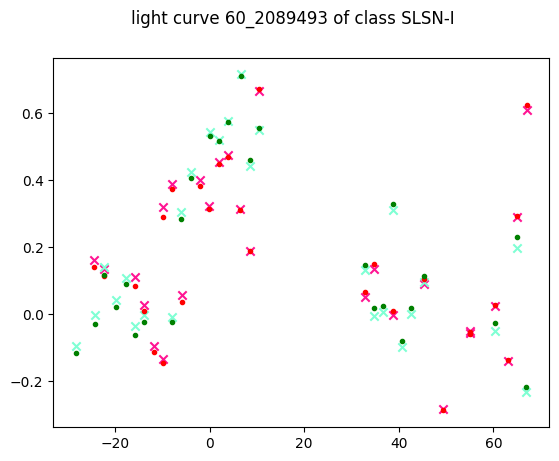

In [15]:
for index in range(15):
  plot_true_and_predicted_light_curve(vae, x_test, names_test, labels_test, index)